 # Feature Store Tour - Python API
 
This notebook contains a tour/reference for the Hopsworks feature store Python API on Amazon SageMaker. The notebook is meant to be run on Amazon SageMaker after setting up Hopsworks to work with AWS [(see here)](https://hopsworks.readthedocs.io/en/latest/user_guide/hopsworks/featurestore.html#connecting-from-amazon-sagemaker).

The notebook is designed to be used in combination with the Feature Store Tour on Hopsworks, it assumes that you have run the following feature engineering job: [job](https://github.com/logicalclocks/hops-examples/tree/master/featurestore_tour) (**the job is added automatically when you start the feature store tour in Hopsworks. You can run the job by going to the 'Jobs' tab to the left in the Hopsworks project home page**). 

Which will produce the following model of feature groups in your project's feature store:

![Feature Store Model](./images/model.png "Feature Store Model")

In this notebook we will run queries over this feature store model. We will also create new feature groups and training datasets.

We will go from (1) features to (2) training datasets to (3) A trained model

## Installation

To access the feature store from SageMaker the hopsworks-cloud-sdk needs to be installed:

In [1]:
!pip install hopsworks-cloud-sdk

You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Imports

In [2]:
from hops import featurestore

## Connecting

This assumes that Hopsworks and AWS were already configured correctly. See [Connecting from Amazon SageMaker](https://hopsworks.readthedocs.io/en/latest/user_guide/hopsworks/featurestore.html#connecting-from-amazon-sagemaker).

In [3]:
featurestore.connect('my_instance.us-east-2.compute.internal', 'demo_featurestore_admin000', 8181, secrets_store = 'secretsmanager')

## Get The Name of The Project's Feature Store

Each project with the feature store service enabled automatically gets its own feature store created. This feature store is only accessible within the project unless you decide to share it with other projects. The name of the feature store is `<project_name>_featurestore`, and you can get the name with the API method `project_featurestore()`. 

In [4]:
featurestore.project_featurestore()

'demo_featurestore_admin000_featurestore'

## Get a List of All Feature Stores Accessible in the Current Project 

Feature Stores can be shared across projects in a multi-tenant manner, just like any Hopsworks-dataset can. You can read more about sharing datasets at [hops.io](hops.io), but in essence to share a dataset you just have to right click on it in your project. The feature groups in the feature store are located in a dataset called `<project_name>_featurestore.db` in your project.

![Share Feature Store](./images/share_featurestore.png "Share Feature Store")

In [5]:
featurestore.get_project_featurestores()

['demo_featurestore_admin000_featurestore']

## Querying The Feature Store

The feature store can be queried programmatically and with raw SQL. When you query the feature store programmatically, the library will infer how to fetch the different features using a **query planner**. 

![Feature Store Query Planner](./images/query_optimizer.png "Feature Store Query Planner")

When interacting with the feature store it is sufficient to be familiar with three concepts:

- The **feature**, this refer to an individual versioned and documented feature in the feature store, e.g the age of a person.
- The **feature group**, this refer to a documented and versioned group of features stored as a Hive table that is linked to a specific Spark/Numpy/Pandas job that takes in raw data and outputs the computed features.
- The **training dataset**, this refer to a versioned and managed dataset of features, stored in HopsFS as tfrecords, .csv, .tsv, or parquet.

A feature group contains a group of features and a training dataset contains a set of features, potentially from many different feature groups.

![Feature Store Concepts](./images/concepts.png "Feature Store Contents")

When you query the feature store you will always get back the results in a pandas dataframe. This is for scalability reasons. If the dataset is small and you want to work with it in memory you can convert it into a pandas dataframe or a numpy matrix using one line of code as we will demonstrate later on in this notebook.

### Fetch an Individual Feature

When retrieving a single feature from the featurestore, the hops-util-py library will infer in which feature group the feature belongs to by querying the metastore, but you can also explicitly specify which featuregroup and version to query. 

If there are multiple features of the same name in the featurestore, it is required to specify enough information to uniquely identify the feature (e.g specify feature group and version). If no featurestore is provided it will default to the project's featurestore.

To read an individual feature, use the method `get_feature(feature_name)`

Without specifying the feature store, feature group and version, the library will infer it:

In [6]:
featurestore.get_feature("team_budget").head(5)

Logical query plan for getting 1 feature from the featurestore created successfully
SQL string for the query created successfully
Running sql: SELECT team_budget FROM teams_features_1 against the offline feature store


,team_budget
0,12957.0760
1,2403.3704
2,3390.3755
3,13547.4290
4,9678.3330


You can also explicitly specify the feature store, feature group, the version, and the return format:

In [7]:
featurestore.get_feature(
    "team_budget", 
    featurestore=featurestore.project_featurestore(), 
    featuregroup="teams_features", 
    featuregroup_version = 1
).head(5)

Logical query plan for getting 1 feature from the featurestore created successfully
SQL string for the query created successfully
Running sql: SELECT team_budget FROM teams_features_1 against the offline feature store


,team_budget
0,12957.0760
1,2403.3704
2,3390.3755
3,13547.4290
4,9678.3330


### Fetch an Entire Feature Group

You can get an entire featuregroup from the API. If no feature store is provided the API will default to the project's feature store, if no version is provided it will default to version 1 of the feature group. The return format is as a pandas dataframe.

In [8]:
featurestore.get_featuregroup("teams_features").head(5)

SQL string for the query created successfully
Running sql: SELECT * FROM teams_features_1 against the offline feature store


,team_budget,team_id,team_position
0,12957.0760,1,1
1,2403.3704,2,2
2,3390.3755,3,3
3,13547.4290,4,4
4,9678.3330,5,5


The default parameters can be overriden:

In [9]:
featurestore.get_featuregroup(
    "teams_features", 
    featurestore=featurestore.project_featurestore(), 
    featuregroup_version = 1
).head(5)

SQL string for the query created successfully
Running sql: SELECT * FROM teams_features_1 against the offline feature store


,team_budget,team_id,team_position
0,12957.0760,1,1
1,2403.3704,2,2
2,3390.3755,3,3
3,13547.4290,4,4
4,9678.3330,5,5


### Fetch A Set of Features

When retrieving a list of features from the featurestore, the hops-util-py library will infer which featuregroup the features belongs to by querying the metastore. If the features reside in different featuregroups, the library will also try to infer how to join the features together based on common columns. If the JOIN query cannot be inferred due to existence of multiple features with the same name or non-obvious JOIN query, the user need to supply enough information to the API call to be able to query the featurestore. If the user already knows the JOIN query it can also run featurestore.sql(joinQuery) directly (an example of this is shown further down in this notebook). If no featurestore is provided the API will default to the project's featurestore.

Example of querying the feature store for a list of features without specifying the feature groups and feature store:

In [10]:
featurestore.get_features(
    ["team_budget", "average_attendance", "average_player_age"]
).head(5)

Logical query plan for getting 3 features from the featurestore created successfully
SQL string for the query created successfully
Running sql: SELECT average_player_age, average_attendance, team_budget FROM players_features_1 JOIN attendances_features_1 JOIN teams_features_1 ON players_features_1.`team_id`=attendances_features_1.`team_id` AND players_features_1.`team_id`=teams_features_1.`team_id` against the offline feature store


,average_player_age,average_attendance,team_budget
0,25.65,3271.9340,16758.0660
1,25.67,2695.4463,14580.9480
2,25.67,2701.0522,9290.6380
3,25.88,92301.0860,12957.0760
4,26.18,2823.9960,4134.0903


We can also explicitly specify the feature groups where the features reside. Either the feature groups and versions can be specified by prepending feature names with `<feature group name>_<feature group version.`, or by providing a dict with entries of `<feature group name> -> <feature group version>`:

In [11]:
featurestore.get_features(
    ["teams_features_1.team_budget", 
     "attendances_features_1.average_attendance", 
     "players_features_1.average_player_age"]
).head(5)

Logical query plan for getting 3 features from the featurestore created successfully
SQL string for the query created successfully
Running sql: SELECT players_features_1.average_player_age, attendances_features_1.average_attendance, teams_features_1.team_budget FROM players_features_1 JOIN attendances_features_1 JOIN teams_features_1 ON players_features_1.`team_id`=attendances_features_1.`team_id` AND players_features_1.`team_id`=teams_features_1.`team_id` against the offline feature store


,average_player_age,average_attendance,team_budget
0,25.65,3271.9340,16758.0660
1,25.67,2695.4463,14580.9480
2,25.67,2701.0522,9290.6380
3,25.88,92301.0860,12957.0760
4,26.18,2823.9960,4134.0903


In [12]:
featurestore.get_features(
    ["team_budget", "average_attendance", "average_player_age"],
    featurestore=featurestore.project_featurestore(),
    featuregroups_version_dict={
        "teams_features": 1, 
        "attendances_features": 1,
        "players_features": 1
    }
).head(5)

Logical query plan for getting 3 features from the featurestore created successfully
SQL string for the query created successfully
Running sql: SELECT average_player_age, average_attendance, team_budget FROM attendances_features_1 JOIN players_features_1 JOIN teams_features_1 ON attendances_features_1.`team_id`=players_features_1.`team_id` AND attendances_features_1.`team_id`=teams_features_1.`team_id` against the offline feature store


,average_player_age,average_attendance,team_budget
0,25.65,3271.9340,16758.0660
1,25.67,2695.4463,14580.9480
2,25.67,2701.0522,9290.6380
3,25.88,92301.0860,12957.0760
4,26.18,2823.9960,4134.0903


If you have a lot of name collisions and it is not obvious how to infer the JOIN query to get the features from the feature store. You can explicitly specify the argument `join_key` to the API (or you can provide the entire SQL query using the API method `.sql` as we will demonstrate later on in the notebook)

In [13]:
featurestore.get_features(
    ["team_budget", "average_attendance", "average_player_age"],
    featurestore=featurestore.project_featurestore(),
    featuregroups_version_dict={
        "teams_features": 1, 
        "attendances_features": 1,
        "players_features": 1
    },
    join_key = "team_id"
).head(5)

Logical query plan for getting 3 features from the featurestore created successfully
SQL string for the query created successfully
Running sql: SELECT average_player_age, average_attendance, team_budget FROM teams_features_1 JOIN attendances_features_1 JOIN players_features_1 ON teams_features_1.`team_id`=attendances_features_1.`team_id` AND teams_features_1.`team_id`=players_features_1.`team_id` against the offline feature store


,average_player_age,average_attendance,team_budget
0,25.65,3271.9340,16758.0660
1,25.67,2695.4463,14580.9480
2,25.67,2701.0522,9290.6380
3,25.88,92301.0860,12957.0760
4,26.18,2823.9960,4134.0903


#### Advanced Eamples of Fetching Sets of Features and Common Pitfalls

Getting 12 features from 4 different feature groups:

In [14]:
featurestore.get_features(
    ["team_budget", "average_attendance", "average_player_age",
    "team_position", "sum_attendance", 
     "average_player_rating", "average_player_worth", "sum_player_age",
     "sum_player_rating", "sum_player_worth", "sum_position", 
     "average_position"
    ]
).head(5)

Logical query plan for getting 12 features from the featurestore created successfully
SQL string for the query created successfully
Running sql: SELECT sum_player_age, average_position, sum_position, average_player_age, average_attendance, sum_player_worth, average_player_rating, sum_attendance, team_position, average_player_worth, sum_player_rating, team_budget FROM players_features_1 JOIN season_scores_features_1 JOIN attendances_features_1 JOIN teams_features_1 ON players_features_1.`team_id`=season_scores_features_1.`team_id` AND players_features_1.`team_id`=attendances_features_1.`team_id` AND players_features_1.`team_id`=teams_features_1.`team_id` against the offline feature store


,sum_player_age,average_position,sum_position,average_player_age,average_attendance,sum_player_worth,average_player_rating,sum_attendance,team_position,average_player_worth,sum_player_rating,team_budget
0,2565.0,55.15,1103.0,25.65,3271.9340,30787.268,322.69797,65438.680,26,307.87268,32269.797,16758.0660
1,2567.0,62.45,1249.0,25.67,2695.4463,22179.488,229.57967,53908.926,36,221.79488,22957.967,14580.9480
2,2567.0,58.45,1169.0,25.67,2701.0522,18485.990,227.61397,54021.043,37,184.85991,22761.396,9290.6380
3,2588.0,29.05,581.0,25.88,92301.0860,792043.250,7191.86330,1846021.800,1,7920.43260,719186.300,12957.0760
4,2618.0,74.15,1483.0,26.18,2823.9960,17936.293,181.49428,56479.920,43,179.36293,18149.428,4134.0903


### Free Text SQL Query from the Feature Store

For complex queries that cannot be inferred by the helper functions, enter the sql directly to the method `featurestore.sql()` it will default to the project specific feature store but you can also specify it explicitly. If you are proficient in SQL, this is the most efficient and preferred way to query the feature store.

Without specifying the feature store the query will by default be run against the project's feature store:

In [15]:
featurestore.sql("SELECT * FROM teams_features_1 WHERE team_position < 5").head(5)

Running sql: SELECT * FROM teams_features_1 WHERE team_position < 5 against the offline feature store


,team_budget,team_id,team_position
0,12957.0760,1,1
1,2403.3704,2,2
2,3390.3755,3,3
3,13547.4290,4,4


You can also specify the featurestore to query explicitly:

In [16]:
featurestore.sql("SELECT * FROM teams_features_1 WHERE team_position < 5",
                featurestore=featurestore.project_featurestore()).head(5)

Running sql: SELECT * FROM teams_features_1 WHERE team_position < 5 against the offline feature store


,team_budget,team_id,team_position
0,12957.0760,1,1
1,2403.3704,2,2
2,3390.3755,3,3
3,13547.4290,4,4


## Featuregroup Visualization

As you will see later on in this tutorial, when writing to the featurestore there is an option to also compute statistics of the features. The computed statistics will be stored as attached metadata of featuregroups and visualized in the feature registry. You can also access the statistics from the python API and visualize it in Jupyter notebooks in `%%local`

### Feature Distributions

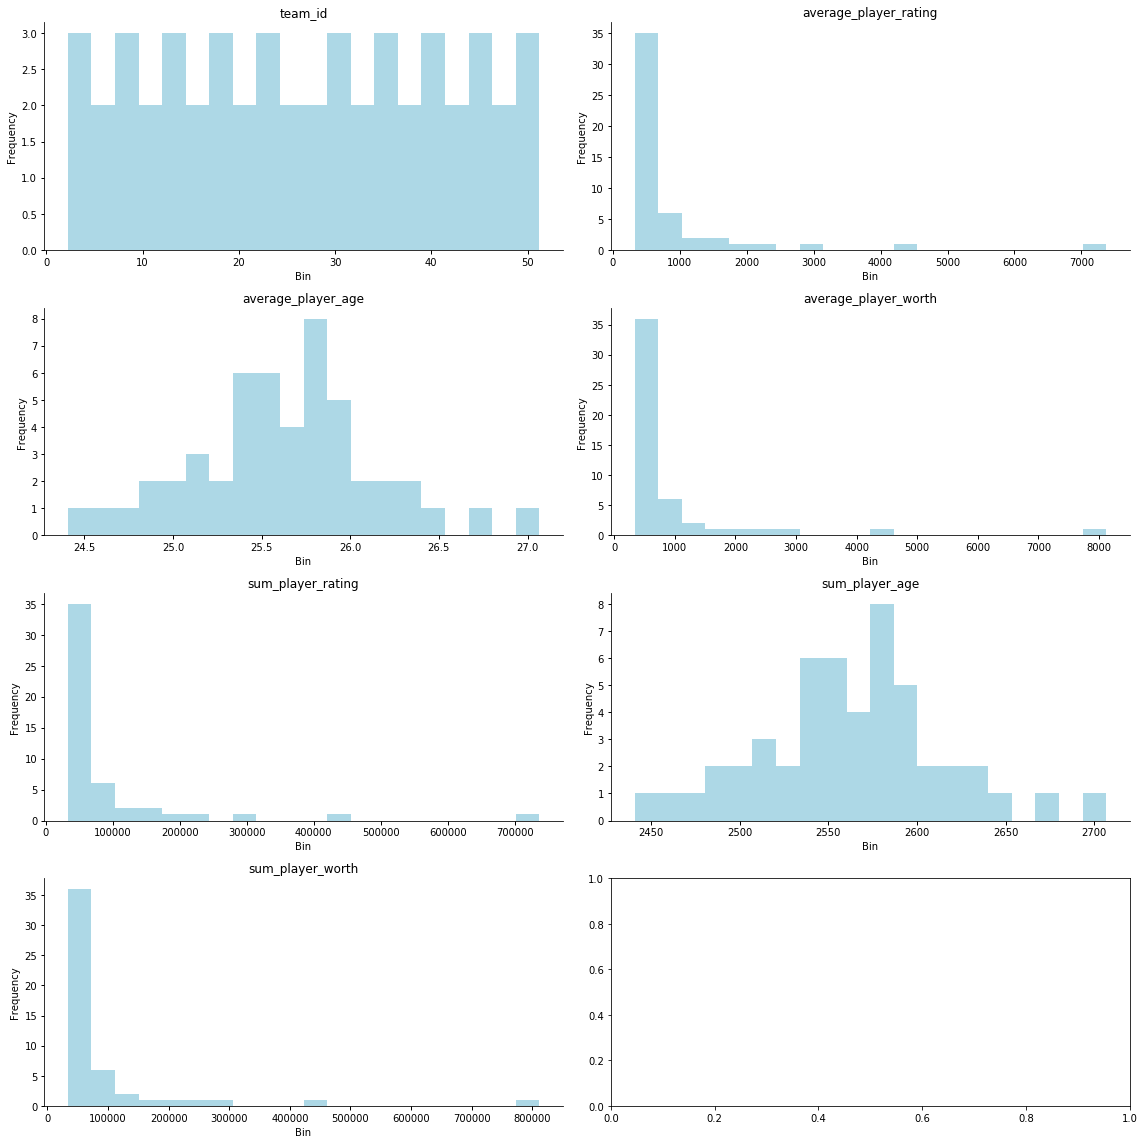

In [17]:
featurestore.visualize_featuregroup_distributions("players_features")

You can also override default parameters and configure the plotting options:

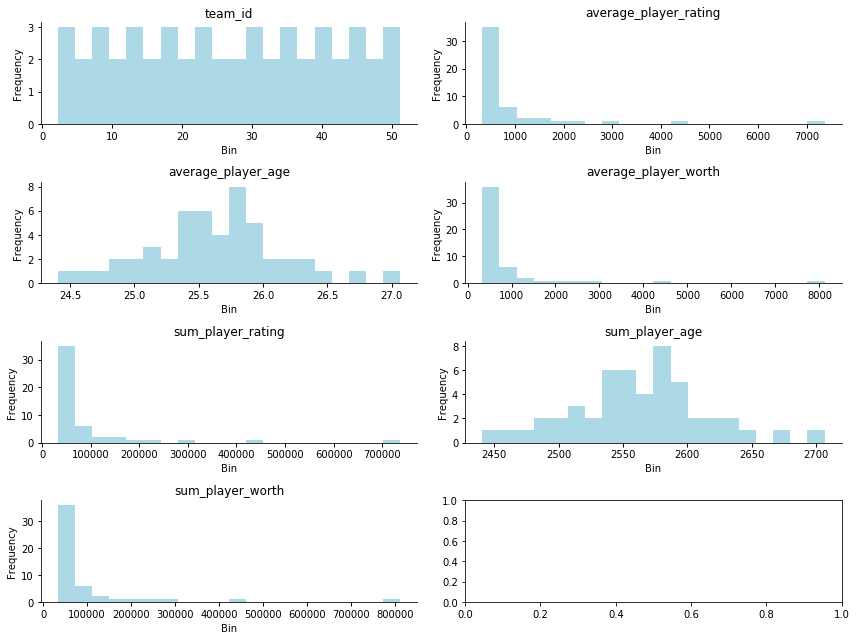

In [18]:
featurestore.visualize_featuregroup_distributions("players_features", 
                                                  featurestore=featurestore.project_featurestore(), 
                                                  featuregroup_version=1, 
                                                  figsize=(12, 9),
                                                  color='lightblue', 
                                                  log=False, 
                                                  align="center", 
                                                  plot=True)

### Feature Correlations

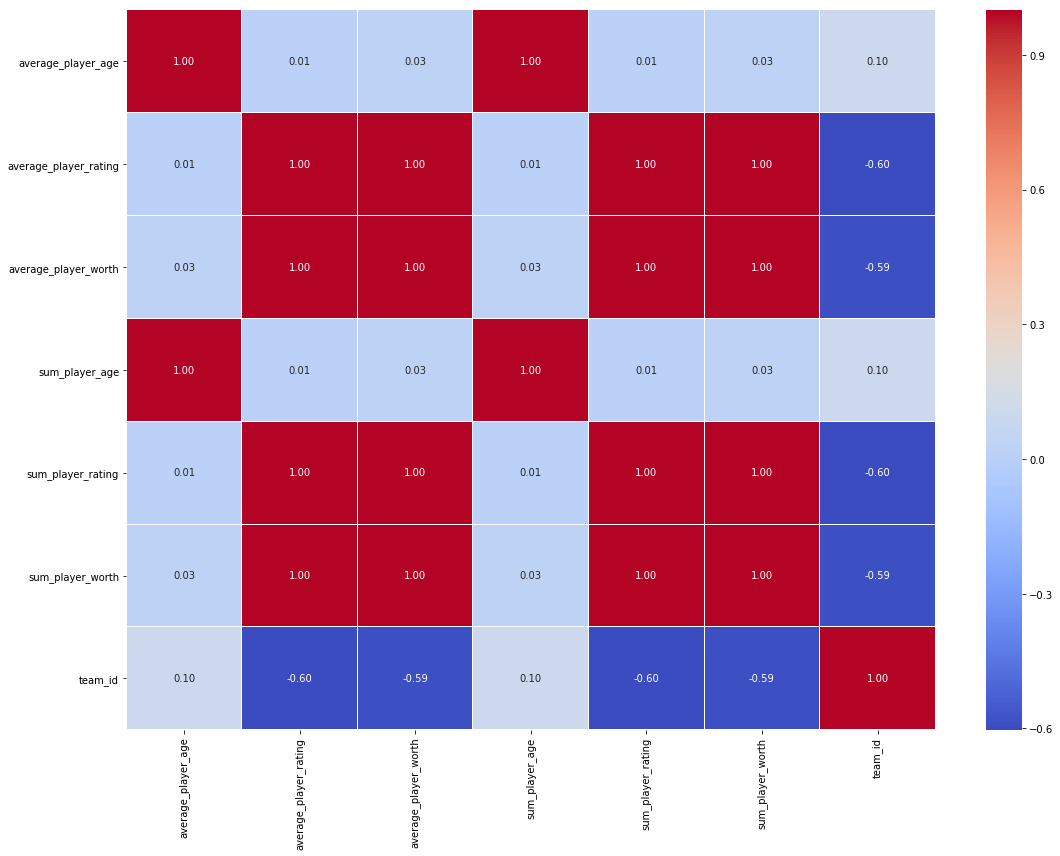

In [19]:
featurestore.visualize_featuregroup_correlations("players_features")

You can also override default parameters and configure the plotting options:

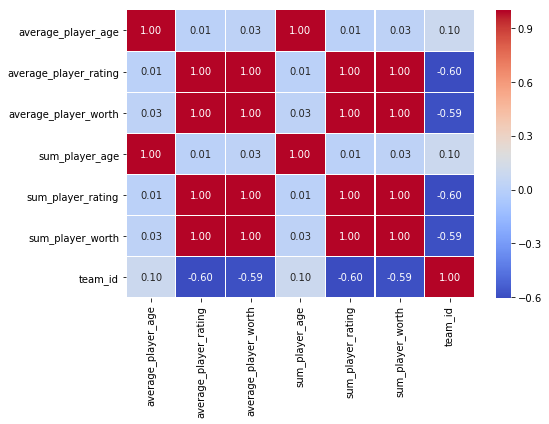

In [20]:
featurestore.visualize_featuregroup_correlations("players_features", 
                                                 featurestore=None, 
                                                 featuregroup_version=1, 
                                                 figsize=(8,6),
                                                 cmap="coolwarm", 
                                                 annot=True, 
                                                 fmt=".2f", 
                                                 linewidths=.05, 
                                                 plot=True)

### Feature Clusters

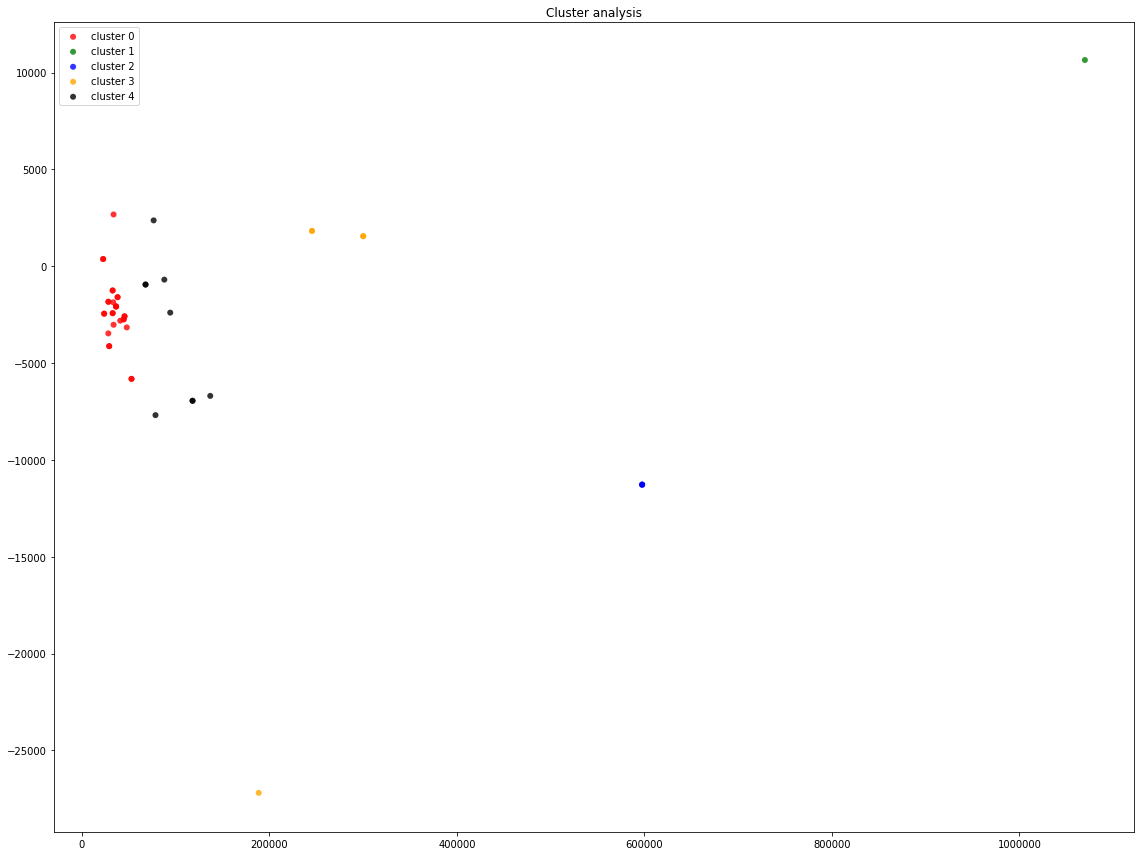

In [21]:
featurestore.visualize_featuregroup_clusters("players_features")

You can also override default parameters and configure the plotting options:

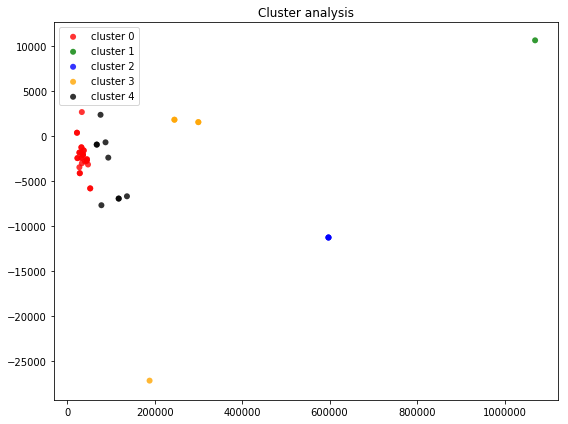

In [22]:
featurestore.visualize_featuregroup_clusters("players_features", 
                                featurestore=None, 
                                featuregroup_version=1, 
                                figsize=(8,6),
                                plot=True)

### Descriptive Stats

In [23]:
desc_stats_df = featurestore.visualize_featuregroup_descriptive_stats("players_features")
desc_stats_df.head()

,metric,sum_player_age,team_id,average_player_age,sum_player_worth,average_player_rating,average_player_worth,sum_player_rating
0,count,50.00000,50.00000,50.000000,50.000,50.00000,50.00000,50.000
1,min,2434.00000,1.00000,24.340000,14229.664,150.96327,142.29665,15096.327
2,mean,2556.84000,25.50000,25.568400,73451.310,717.38370,734.51310,71738.375
3,stddev,52.29132,14.57738,0.522913,128564.730,1187.08750,1285.64720,118708.750
4,max,2700.00000,50.00000,27.000000,792043.250,7191.86330,7920.43260,719186.300


## Training Datasets

To group data in the feature store we use three concepts:

- Feature
- Feature group
- Training Dataset

Typically during the feature engineering phase of a machine learning project, you compute a set of features for each type of data that you have, these features are naturally grouped into a documented and versioned **feature group**. 

In practice, it is common that organizations have many different type of datasets that they can extract features from, for example if you are building a recommendation system you might have demographic data about each user as well as user-activity data. 

When you train a machine learning model, you want to use all features that have predictive power and that the model can learn from. At this point, we can create a training dataset of features from several different feature groups and use that for training. That is the purpose of the training dataset abstraction. 

Of course you can always just save a group of features anywhere inside your project, e.g as a csv, or .tfrecords file. However, by using the feature store you can create **managed** training datasets. Managed training datasets will show up in the feature registry UI and will automatically be versioned, documented and reproducible. 

Once a training dataset have been created you can find it in the featurestore UI in hopsworks under the tab `Training datasets`, from there you can also edit the metadata if necessary. 

### Get Training Dataset Path

After a **managed dataset** have been created, it is easy to share it and re-use it for training various models. For example if the dataset have been materialized in tf-records format you can call the method `get_training_dataset_path(training_dataset)` to get the HDFS path and read it directly in your tensorflow code.

In [25]:
featurestore.get_training_dataset_path("tour_training_dataset_test")

'/Projects/demo_featurestore_admin000/demo_featurestore_admin000_Training_Datasets/tour_training_dataset_test_1/tour_training_dataset_test'

By default the library will look for the training dataset in the project's featurestore and use version 1, but this can be overriden if required:

In [26]:
featurestore.get_training_dataset_path(
    "tour_training_dataset_test", 
    featurestore=featurestore.project_featurestore(),
    training_dataset_version=featurestore.get_latest_training_dataset_version("tour_training_dataset_test")
)

'/Projects/demo_featurestore_admin000/demo_featurestore_admin000_Training_Datasets/tour_training_dataset_test_1/tour_training_dataset_test'

### Training Dataset Visualization

Just as for featuregroups, the training dataset statistics can be visualized in the Jupyter notebook in `%%local`.

#### Feature Distributions

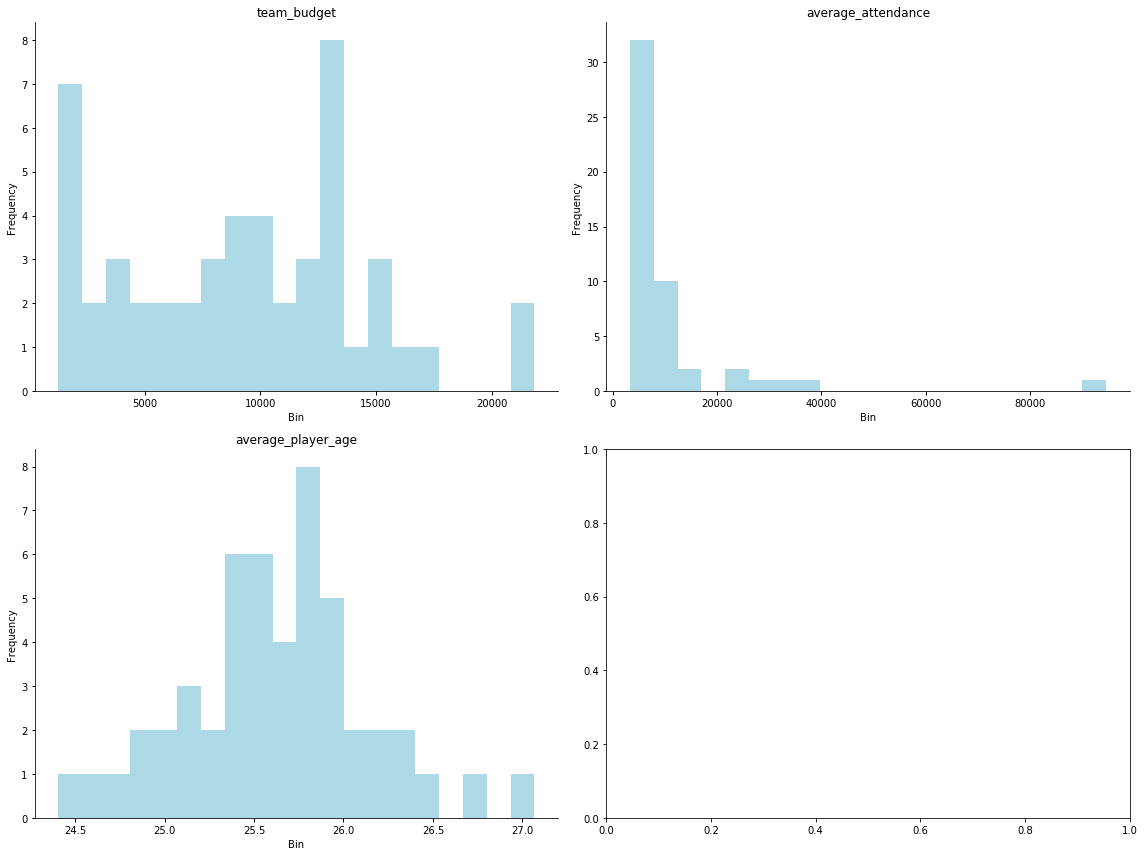

In [27]:
featurestore.visualize_training_dataset_distributions("tour_training_dataset_test")

You can also override default parameters and set plotting configuration:

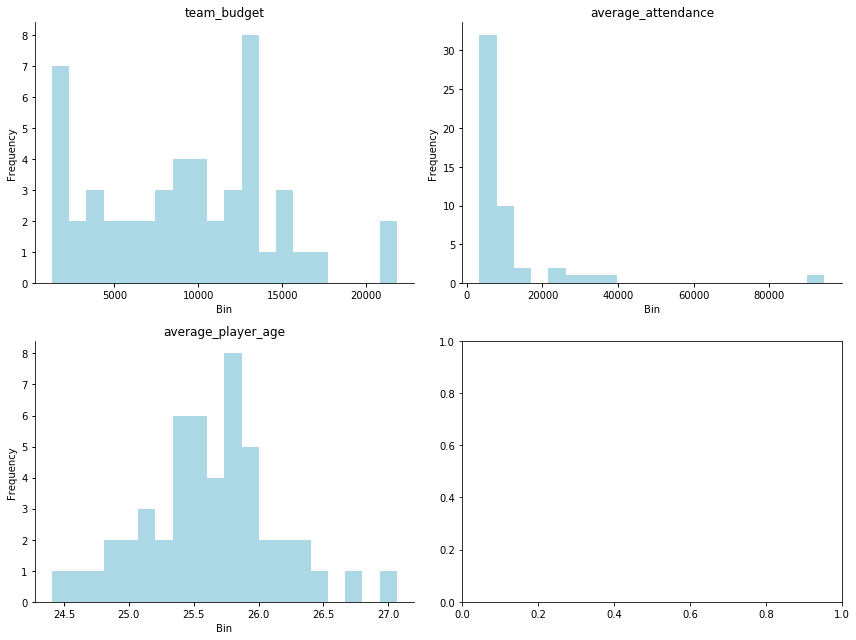

In [28]:
featurestore.visualize_training_dataset_distributions("tour_training_dataset_test", 
                                                  featurestore=featurestore.project_featurestore(), 
                                                  training_dataset_version=1, 
                                                  figsize=(12, 9),
                                                  color='lightblue', 
                                                  log=False, 
                                                  align="center", 
                                                  plot=True)

#### Feature Correlations

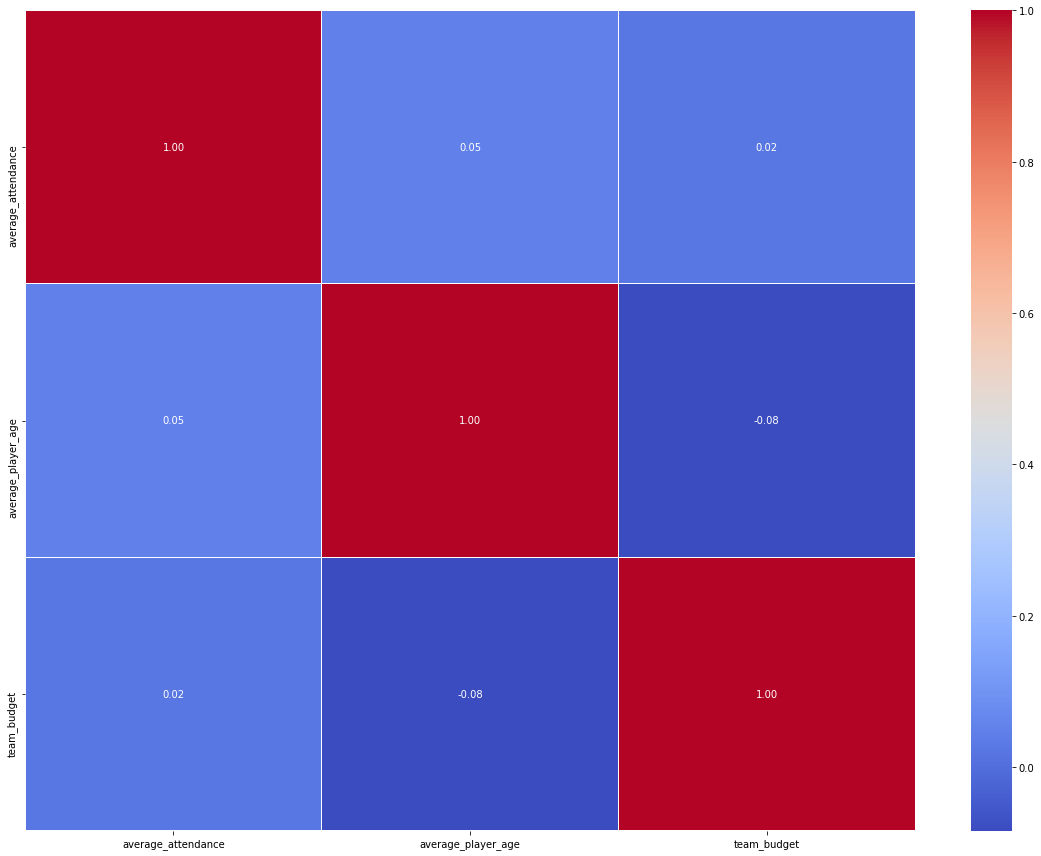

In [29]:
featurestore.visualize_training_dataset_correlations("tour_training_dataset_test")

You can also override default parameters and set plotting configuration:

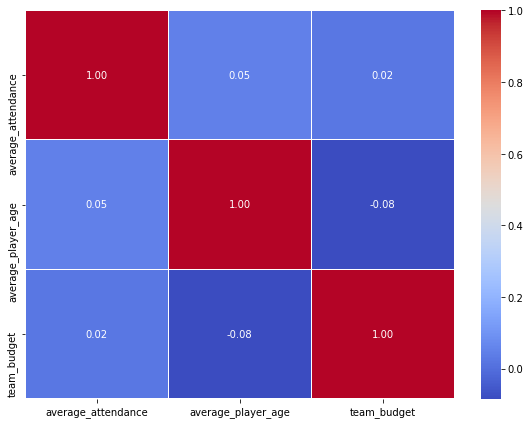

In [30]:
featurestore.visualize_training_dataset_correlations("tour_training_dataset_test", 
                                                 featurestore=None, 
                                                 training_dataset_version=1, 
                                                 figsize=(8,6),
                                                 cmap="coolwarm", 
                                                 annot=True, 
                                                 fmt=".2f", 
                                                 linewidths=.05, 
                                                 plot=True)

#### Feature Clusters

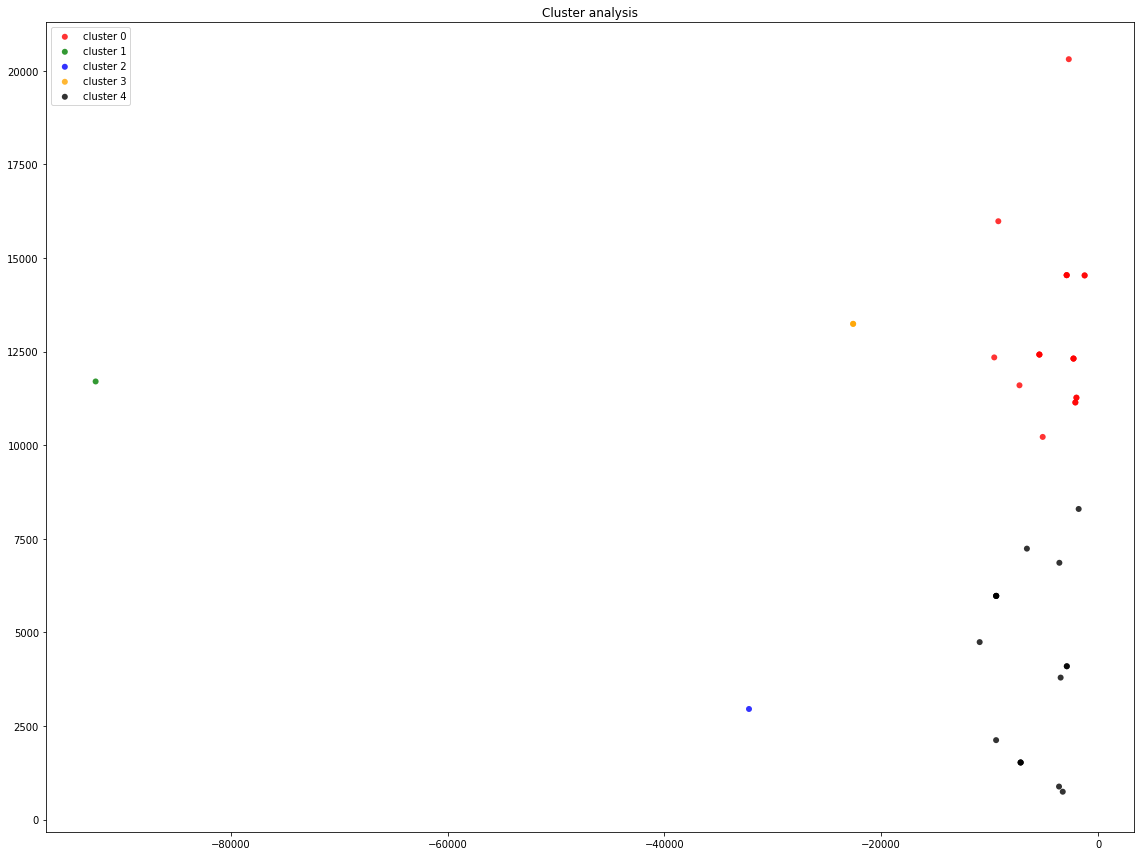

In [31]:
featurestore.visualize_training_dataset_clusters("tour_training_dataset_test")

You can also override default parameters and set plotting configuration:

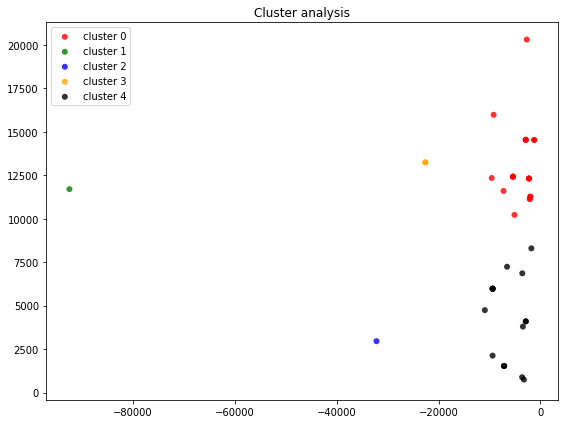

In [32]:
featurestore.visualize_training_dataset_clusters("tour_training_dataset_test", 
                                featurestore=None, 
                                training_dataset_version=1, 
                                figsize=(8,6),
                                plot=True)

#### Descriptive Stats

In [33]:
desc_stats_df = featurestore.visualize_training_dataset_descriptive_stats("tour_training_dataset_test")
desc_stats_df.head()

,metric,average_player_age,average_attendance,team_budget
0,count,50.000000,50.0000,50.0000
1,min,24.340000,1038.5237,760.8729
2,mean,25.568400,8669.3940,8723.2920
3,stddev,0.522913,14232.3090,5238.9430
4,max,27.000000,92301.0860,21319.5330


Since descriptive stats is just a pandas table and not a matplotlib figure it does not need a DISPLAY to work, so you can run it from the spark driver or executor as well:

In [34]:
desc_stats_df = featurestore.visualize_training_dataset_descriptive_stats("tour_training_dataset_test")
desc_stats_df.head()

,metric,average_player_age,average_attendance,team_budget
0,count,50.000000,50.0000,50.0000
1,min,24.340000,1038.5237,760.8729
2,mean,25.568400,8669.3940,8723.2920
3,stddev,0.522913,14232.3090,5238.9430
4,max,27.000000,92301.0860,21319.5330


## Get Featurestore Metadata
To explore the contents of the featurestore we recommend using the featurestore page in the Hopsworks UI but you can also get the metadata programmatically from the REST API

### Update Metadata Cache

In [35]:
featurestore.get_featurestore_metadata(update_cache=True)

### List all Feature Stores Accessible In the Project

In [36]:
featurestore.get_project_featurestores()

['demo_featurestore_admin000_featurestore']

### List all Feature Groups in a Feature Store

In [37]:
featurestore.get_featuregroups()

['games_features_1',
 'games_features_on_demand_tour_1',
 'games_features_hudi_tour_1',
 'season_scores_features_1',
 'attendances_features_1',
 'players_features_1',
 'teams_features_1']

By default `get_featuregroups()` will use the project's feature store, but this can also be specified with the optional argument featurestore

In [38]:
featurestore.get_featuregroups(featurestore=featurestore.project_featurestore())

['games_features_1',
 'games_features_on_demand_tour_1',
 'games_features_hudi_tour_1',
 'season_scores_features_1',
 'attendances_features_1',
 'players_features_1',
 'teams_features_1']

### List all Features in a Feature Store

In [39]:
featurestore.get_features_list()

['away_team_id',
 'home_team_id',
 'score',
 'away_team_id',
 'home_team_id',
 '_hoodie_commit_seqno',
 '_hoodie_commit_time',
 '_hoodie_file_name',
 '_hoodie_partition_path',
 '_hoodie_record_key',
 'score',
 'average_position',
 'sum_position',
 'team_id',
 'average_attendance',
 'sum_attendance',
 'team_id',
 'average_player_age',
 'average_player_rating',
 'average_player_worth',
 'sum_player_age',
 'sum_player_rating',
 'sum_player_worth',
 'team_id',
 'team_budget',
 'team_id',
 'team_position']

By default get_features_list() will use the project's feature store, but this can also be specified with the optional argument featurestore

In [40]:
featurestore.get_features_list(featurestore=featurestore.project_featurestore())

['away_team_id',
 'home_team_id',
 'score',
 'away_team_id',
 'home_team_id',
 '_hoodie_commit_seqno',
 '_hoodie_commit_time',
 '_hoodie_file_name',
 '_hoodie_partition_path',
 '_hoodie_record_key',
 'score',
 'average_position',
 'sum_position',
 'team_id',
 'average_attendance',
 'sum_attendance',
 'team_id',
 'average_player_age',
 'average_player_rating',
 'average_player_worth',
 'sum_player_age',
 'sum_player_rating',
 'sum_player_worth',
 'team_id',
 'team_budget',
 'team_id',
 'team_position']

### List all Training Datasets in a Feature Store

In [41]:
featurestore.get_training_datasets()

['tour_training_dataset_test_1']

By default `get_training_datasets()` will use the project's feature store, but this can also be specified with the optional argument featurestore

In [42]:
featurestore.get_training_datasets(featurestore=featurestore.project_featurestore())

['tour_training_dataset_test_1']

### List all Storage Connectors in a Feature Store

In [43]:
featurestore.get_storage_connectors()

[('demo_featurestore_admin000_featurestore', 'JDBC'),
 ('demo_featurestore_admin000', 'JDBC'),
 ('demo_featurestore_admin000_meb1_onlinefeaturestore', 'JDBC'),
 ('demo_featurestore_admin000_Training_Datasets', 'HOPSFS')]

By default `get_storage_connectors()` will use the project's feature store, but this can also be specified with the optional argument featurestore

In [44]:
featurestore.get_storage_connectors(featurestore=featurestore.project_featurestore())

[('demo_featurestore_admin000_featurestore', 'JDBC'),
 ('demo_featurestore_admin000', 'JDBC'),
 ('demo_featurestore_admin000_meb1_onlinefeaturestore', 'JDBC'),
 ('demo_featurestore_admin000_Training_Datasets', 'HOPSFS')]

### Get All Metadata (Features, Feature groups, Training Datasets) for a Feature Store

In [45]:
featurestore.get_featurestore_metadata()

By default `get_featurestore_metadata` will use the project's feature store, but this can also be specified with the optional argument featurestore

In [46]:
featurestore.get_featurestore_metadata(featurestore=featurestore.project_featurestore())